In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from xgboost import XGBClassifier
RANDOM_STATE = 55 #hyperparam for XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print(train_data.head())

# Dropping null data points 
print(f'Train data shape before dropping null values: {train_data.shape}')
train_data.dropna(subset=['CryoSleep', 'Cabin', 'VIP', 'ShoppingMall'], inplace=True)
print(f'Train data shape after dropping null values: {train_data.shape}')

total_num_training_vals = train_data.shape[0]
NUM_BINS = math.ceil(np.sqrt(total_num_training_vals))

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
Tr

# Exploratory Data Analysis

Text(0.5, 1.0, 'Count Plot of Transported status, by HomePlanet')

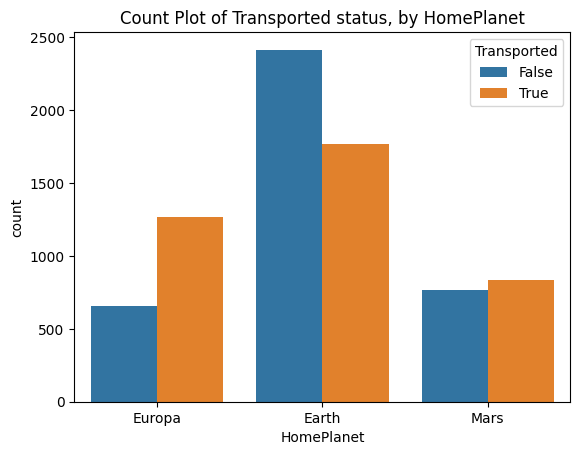

In [3]:
# Countplots for each HomePlanet
sns.countplot(data=train_data, x='HomePlanet', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by HomePlanet")

Text(0.5, 1.0, 'Count Plot of Transported status, by CryoSleep status')

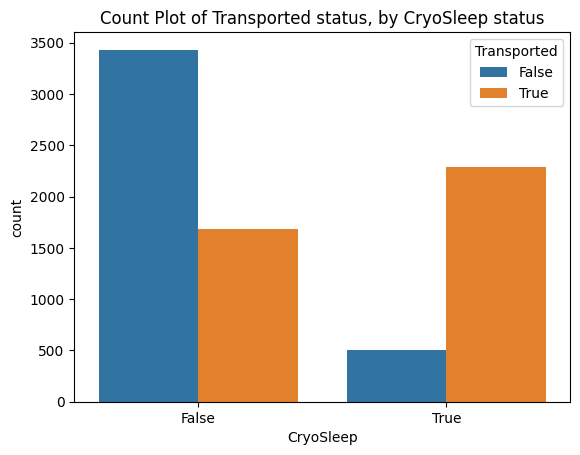

In [4]:
# Countplots for each CryoSleep status
sns.countplot(data=train_data, x='CryoSleep', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by CryoSleep status")

Text(0.5, 1.0, 'Count Plot of Transported status, by Destination')

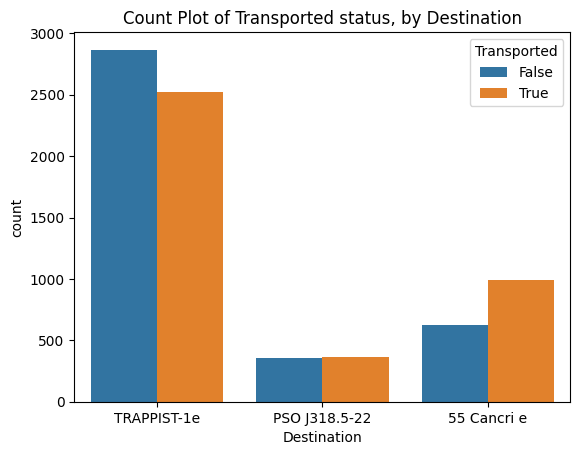

In [5]:
# Countplots for each Destination
sns.countplot(data=train_data, x='Destination', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by Destination")

Text(0.5, 1.0, 'Count Plot of Transported status, by VIP status')

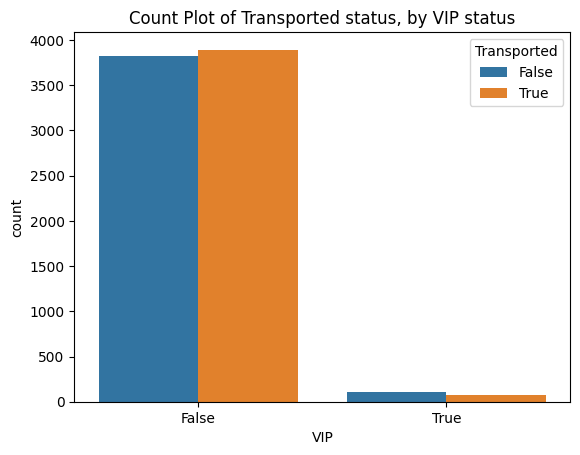

In [6]:
# Countplot for each VIP status
sns.countplot(data=train_data, x='VIP', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by VIP status")

In [7]:
# Creating new features: Deck, Side
# Num is not added as a feature since it's not discrete and I assume that general cabin area matters more than specific room Num
train_data['Deck'] = train_data['Cabin'].str.split(pat='/', expand=True)[0]
train_data['Num'] = train_data['Cabin'].str.split(pat='/', expand=True)[1]
train_data['Side'] = train_data['Cabin'].str.split(pat='/', expand=True)[2]

Text(0.5, 1.0, 'Count Plot of Transported status, by Deck')

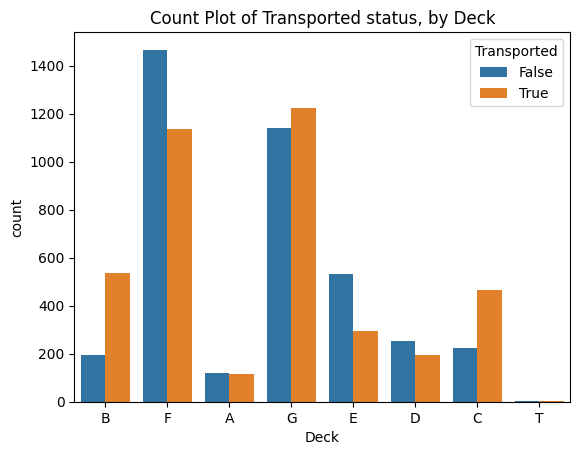

In [8]:
# Count plots for each Deck
sns.countplot(data=train_data, x='Deck', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by Deck")

Text(0.5, 1.0, 'Count Plot of Transported status, by Side')

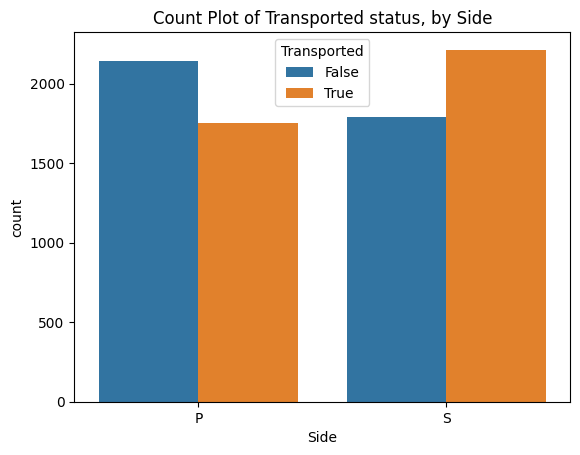

In [9]:
# Countplots for each Side
sns.countplot(data=train_data, x='Side', hue='Transported')

# Add title
plt.title("Count Plot of Transported status, by Side")

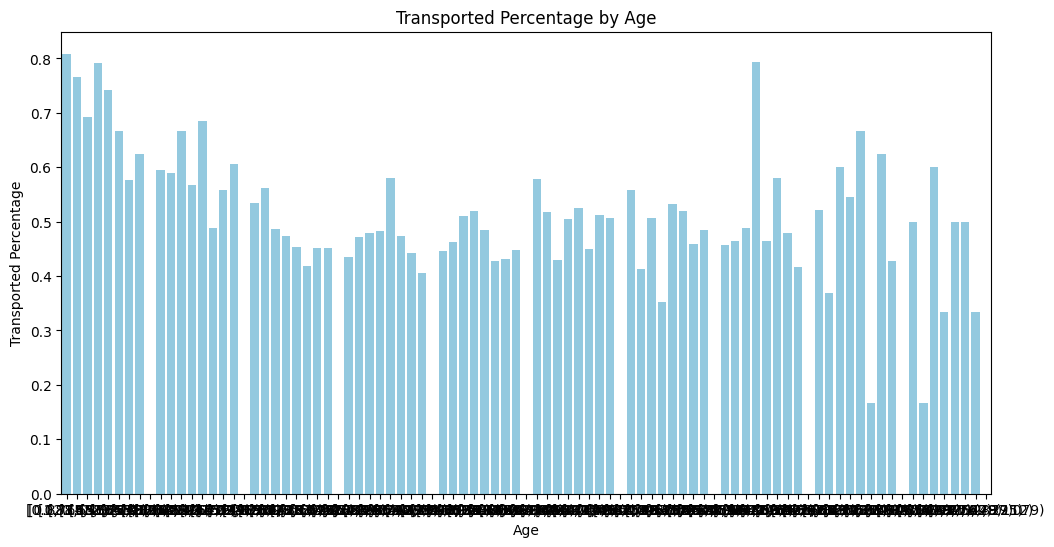

In [10]:
# Create a new column 'AgeGroup' based on the age bins
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('AgeGroup')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('Age')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by Age')

plt.show()

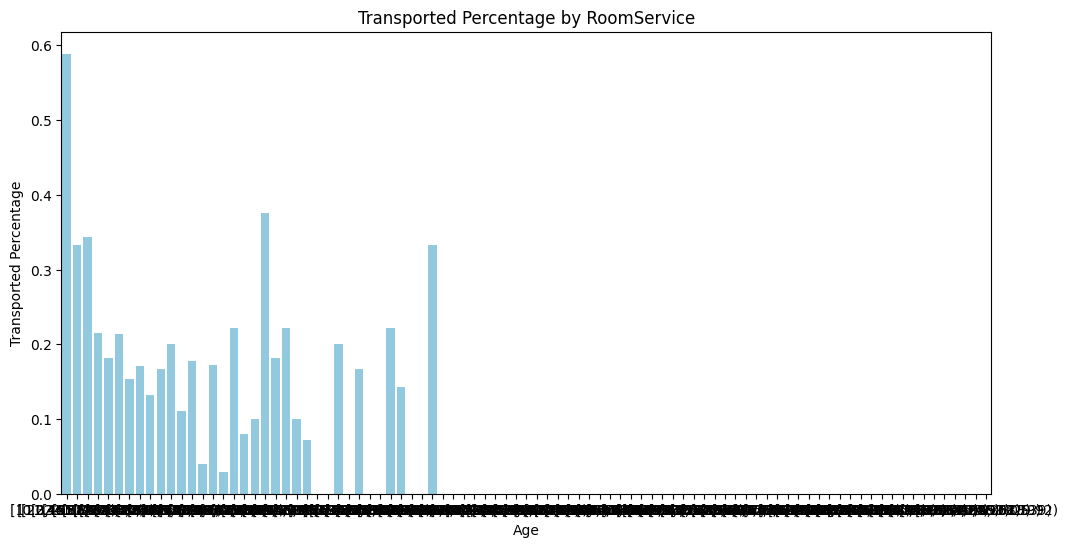

In [11]:
# Percent of people with a given RoomService range who were Transported
train_data['RoomServiceRange'] = pd.cut(train_data['RoomService'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('RoomServiceRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='RoomServiceRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('Age')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by RoomService')

plt.show()

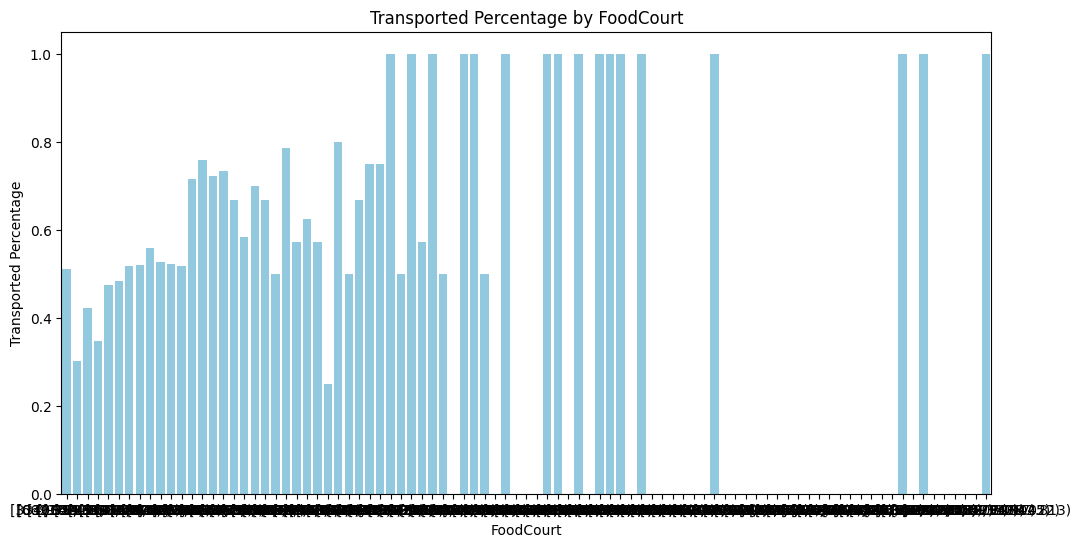

In [12]:
# Percent of people with a given FoodCourt range who were Transported
train_data['FoodCourtRange'] = pd.cut(train_data['FoodCourt'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('FoodCourtRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='FoodCourtRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('FoodCourt')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by FoodCourt')

plt.show()

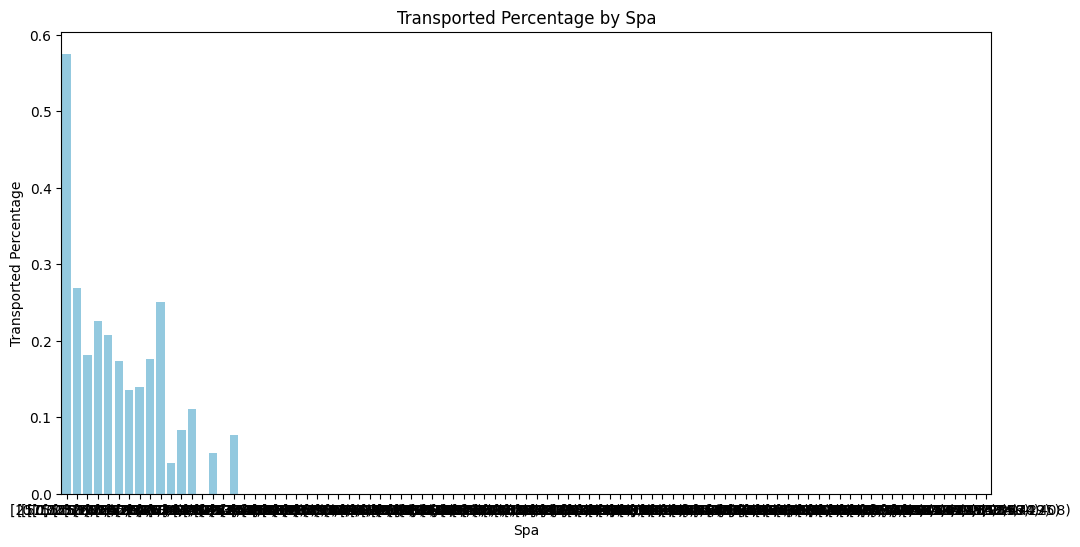

In [13]:
# Percent of people with a given Spa range who were Transported
train_data['SpaRange'] = pd.cut(train_data['Spa'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('SpaRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='SpaRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('Spa')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by Spa')

plt.show()

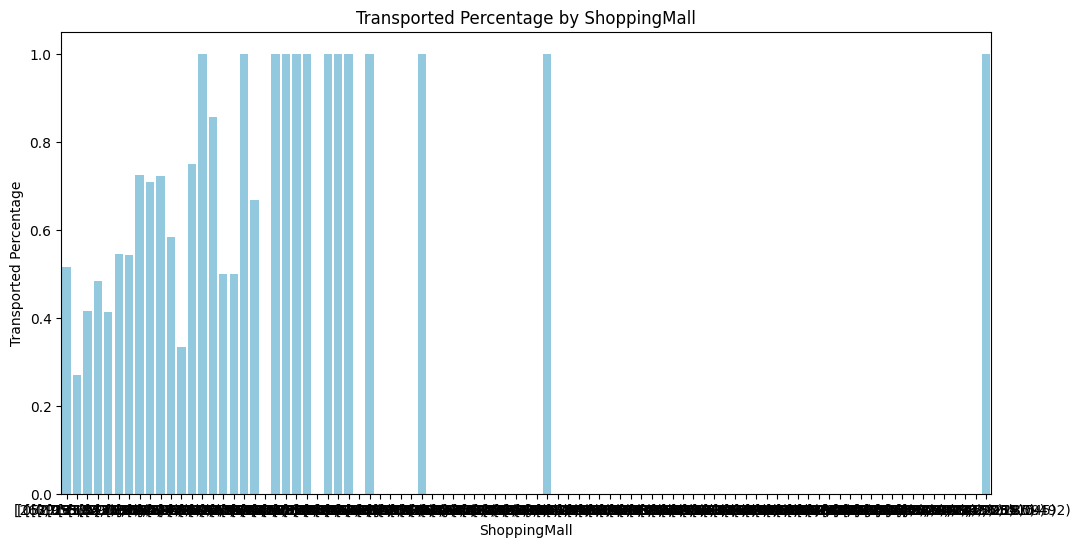

In [14]:
# Percent of people with a given ShoppingMall range who were Transported
train_data['ShoppingMallRange'] = pd.cut(train_data['ShoppingMall'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('ShoppingMallRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='ShoppingMallRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('ShoppingMall')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by ShoppingMall')

plt.show()

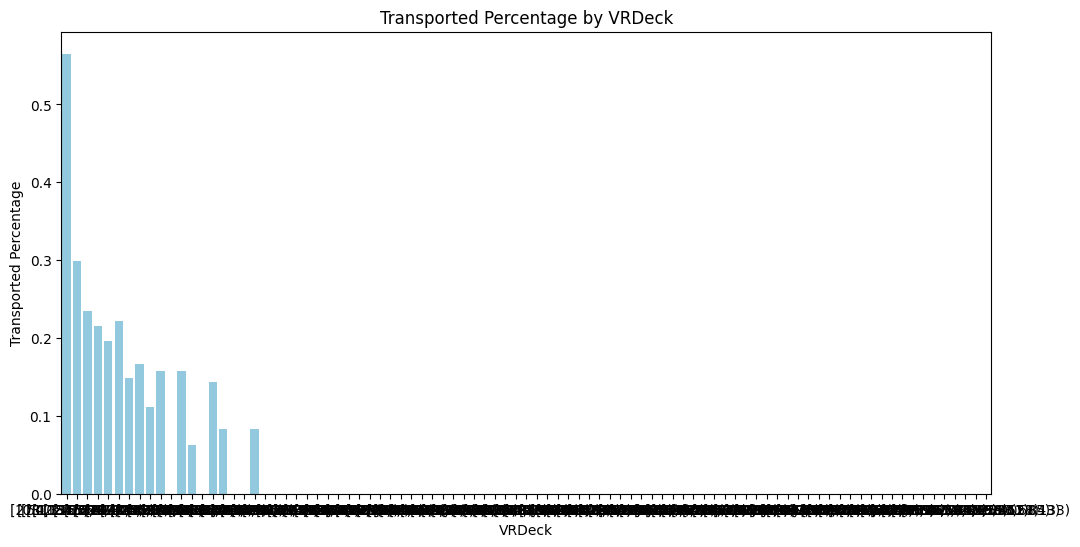

In [15]:
# Percent of people with a given VRDeck range who were Transported
train_data['VRDeckRange'] = pd.cut(train_data['VRDeck'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('VRDeckRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='VRDeckRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('VRDeck')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by VRDeck')

plt.show()

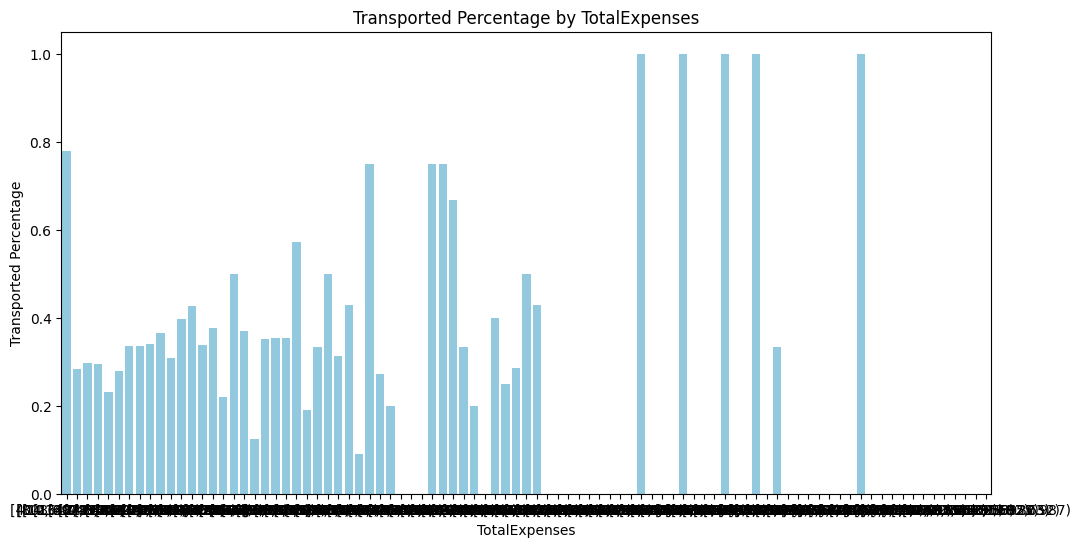

In [16]:
# Additional feature: TotalExpenses(RoomService + FoodCourt + Spa + ShoppingMall + VRDeck)
train_data['TotalExpenses'] = train_data[['RoomService', 'FoodCourt', 'Spa', 'ShoppingMall', 'VRDeck']].sum(axis=1)

# Percent of people with a given TotalExpenses range who were Transported
train_data['TotalExpensesRange'] = pd.cut(train_data['TotalExpenses'], bins=NUM_BINS, right=False)

transported_data = train_data.groupby('TotalExpensesRange')['Transported'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='TotalExpensesRange', y='Transported', data=transported_data, color='skyblue')

plt.xlabel('TotalExpenses')
plt.ylabel('Transported Percentage')
plt.title('Transported Percentage by TotalExpenses')

plt.show()

## Analysis
After running the EDA, the following categorical variables appear to exhibit stronger correlations with transportation status: CryoSleep, HomePlanet, and Deck. The other categorical variables do not appear to have as strong a correlation. So, the first iteration of my model will select these as input features.

The following continuous variables demonstrated non-uniform distributions of transportation likelihood: RoomService, Spa, VRDeck, and TotalExpenses. However, since TotalExpenses embodies the other variables too, my model will just use TotalExpenses. NOTE: This may be a naive approach, but I'm still learning :).

# Model: XGBoost

In [17]:
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [18]:
features = ['HomePlanet', 'CryoSleep', 'Deck', 'TotalExpenses']

X_cat = train_data[features]
X = pd.get_dummies(X_cat, columns=['HomePlanet', 'Deck', 'CryoSleep'], dtype=int)

y = train_data['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

In [19]:
# Adding Deck and TotalExpenses features to test_data
test_data['Deck'] = test_data['Cabin'].str.split(pat='/', expand=True)[0]
test_data['TotalExpenses'] = test_data[['RoomService', 'FoodCourt', 'Spa', 'ShoppingMall', 'VRDeck']].sum(axis=1)

X_test_cat = test_data[features]
X_test = pd.get_dummies(X_test_cat, columns=['HomePlanet', 'Deck', 'CryoSleep'], dtype=int)

In [20]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=RANDOM_STATE, early_stopping_rounds=10, enable_categorical=True)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-logloss:0.66326
[1]	validation_0-logloss:0.63873
[2]	validation_0-logloss:0.61840
[3]	validation_0-logloss:0.60132
[4]	validation_0-logloss:0.58687
[5]	validation_0-logloss:0.57462
[6]	validation_0-logloss:0.56436
[7]	validation_0-logloss:0.55591
[8]	validation_0-logloss:0.54776
[9]	validation_0-logloss:0.54056
[10]	validation_0-logloss:0.53540
[11]	validation_0-logloss:0.52984
[12]	validation_0-logloss:0.52495
[13]	validation_0-logloss:0.52112
[14]	validation_0-logloss:0.51775
[15]	validation_0-logloss:0.51385
[16]	validation_0-logloss:0.51098
[17]	validation_0-logloss:0.50885
[18]	validation_0-logloss:0.50667
[19]	validation_0-logloss:0.50530
[20]	validation_0-logloss:0.50351
[21]	validation_0-logloss:0.50246
[22]	validation_0-logloss:0.50105
[23]	validation_0-logloss:0.50001
[24]	validation_0-logloss:0.49910
[25]	validation_0-logloss:0.49845
[26]	validation_0-logloss:0.49774
[27]	validation_0-logloss:0.49720
[28]	validation_0-logloss:0.49637
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [21]:
predictions = xgb_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': predictions.astype(dtype=bool)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
